# Preprocess

## Init

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from string import ascii_lowercase
from utils import examine_df, monitor
from sklearn.datasets.lfw import Bunch
from raw_preprocessor import RawPreprocessor
from more_itertools import unique_everseen, take
from langdetect import detect as detect_lang, detect_langs

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
args = Bunch()

## Read

In [6]:
_data_base_path = 'code-docstring-corpus/V2/parallel'
args.toplevelfuncs_desc_path = os.path.join(_data_base_path, 'parallel_desc')
args.methods_desc_path = os.path.join(_data_base_path, 'parallel_methods_desc')
args.desc_paths = [args.toplevelfuncs_desc_path, args.methods_desc_path]
args.max_descs = 1000000

In [7]:
def read_desc_gen(file_path):
    with open(file_path, 'r', errors='ignore') as f:
        for line in f:
            yield line.strip()[1:-1].strip()
            
            
def read_all_descs():
    all_gen = (read_desc_gen(desc_path) for desc_path in args.desc_paths)
    return list(take(args.max_descs, unique_everseen(chain.from_iterable(all_gen))))

In [8]:
%time descs = read_all_descs()
print(f'len={len(descs)}')
random.sample(descs, 3)

CPU times: user 800 ms, sys: 72 ms, total: 872 ms
Wall time: 874 ms
len=357220


['list profiles that are bundled with IPython.',
 ':param entry: a HostQueueEntry or a SpecialTask',
 'Get the string representation of this EdgePair.']

## Preprocessing

In [9]:
args.log_step = 5000

In [10]:
raw = [{'text': desc} for desc in descs]
random.sample(raw, 3)

[{'text': 'Delete virtual network. This operation can take a while to complete. DCNL :param resource_group_name: The name of the resource group. DCNL :type resource_group_name: str DCNL :param lab_name: The name of the lab. DCNL :type lab_name: str DCNL :param name: The name of the virtual network. DCNL :type name: str DCNL :param dict custom_headers: headers that will be added to the request DCNL :param bool raw: returns the direct response alongside the DCNL deserialized response DCNL :rtype: DCNL :class:`AzureOperationPoller<msrestazure.azure_operation.AzureOperationPoller>` DCNL instance that returns None DCNL :rtype: :class:`ClientRawResponse<msrest.pipeline.ClientRawResponse>` DCNL if raw=true DCNL :raises: :class:`CloudError<msrestazure.azure_exceptions.CloudError>`'},
 {'text': 'Called when the given test has been run'},
 {'text': 'Verify the request for rendering a markdown document.'}]

In [11]:
preprocessor = RawPreprocessor(
    monitor=monitor('[1.1.1] Docstring preprocessing', log_step=args.log_step),
    do_tqdm=True
)
df = preprocessor.fit_transform(raw)
examine_df(df)

100%|██████████| 357220/357220 [4:46:09<00:00, 20.81it/s]  


shape=(308571, 2)


name                                                        text    tags
pos                                                            0       1
head 0         load a Python source file and compile it to by...     NaN
     1         load a module without importing it DCNL _load_...     NaN
     2         Compare two code-objects. DCNL This is the mai...     NaN
     3                   Compare a .pyc with a source code file.     NaN
     4                           Find globals in this statement.     NaN
tail 308566    Handle ``grant_type=authorization_code`` reque...     NaN
     308567    Handle ``grant_type=refresh_token`` requests a...     NaN
     308568    Return a function or method that is capable ha...     NaN
     308569    As per :rfc:`3.2` the token endpoint *only* su...     NaN
     308570    As per :rfc:`3.2` the token endpoint *only* su...     NaN
meta type                                                 object  object
     has_null                                              False   False
math count                                                308571  308571
     unique                                               308566       1
     top                   KBEngine method. DCNL globalData NASC     NaN
     freq                                                      4  308571

## Sanity check

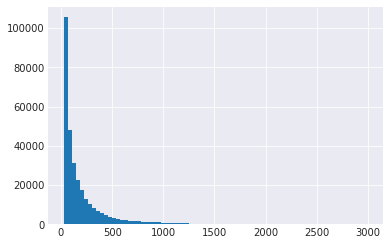

In [12]:
df.text.map(len).hist(bins=75);

In [13]:
df.text.sample(10).tolist()

['test _makeInfoFiles() when open() fails and quiet flag is enabled',
 "Helper method for constructing grammars of expressions made up of DCNL operators working in a precedence hierarchy.  Operators may be unary or DCNL binary, left- or right-associative.  Parse actions can also be attached DCNL to operator expressions. DCNL Parameters: DCNL - baseExpr - expression representing the most basic element for the nested DCNL - opList - list of tuples, one for each operator precedence level in the DCNL expression grammar; each tuple is of the form DCNL (opExpr, numTerms, rightLeftAssoc, parseAction), where: DCNL - opExpr is the pyparsing expression for the operator; DCNL may also be a string, which will be converted to a Literal; DCNL if numTerms is 3, opExpr is a tuple of two expressions, for the DCNL two operators separating the 3 terms DCNL - numTerms is the number of terms for this operator (must DCNL be 1, 2, or 3) DCNL - rightLeftAssoc is the indicator whether the operator is DCNL righ

## Save

In [14]:
args.save_path = 'docstring_data.hdf5'

In [15]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 436 ms, sys: 184 ms, total: 620 ms
Wall time: 1.85 s


In [16]:
!du -sh $args.save_path

66M	docstring_data.hdf5


## End

In [17]:
args

{'desc_paths': ['../code-docstring-corpus/V2/parallel/parallel_desc',
  '../code-docstring-corpus/V2/parallel/parallel_methods_desc'],
 'log_step': 5000,
 'max_descs': 1000000,
 'methods_desc_path': '../code-docstring-corpus/V2/parallel/parallel_methods_desc',
 'save_path': 'docstring_data.hdf5',
 'toplevelfuncs_desc_path': '../code-docstring-corpus/V2/parallel/parallel_desc'}